# News Headlines Sarcasm Detection using CNN

In this notebook, I will be using the [News headlines dataset](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/kernels) by Rishabh Misra. 
The dataset consists of many records with article_link,headline and is_sarcastic field where is_sarcastic field is 1 if headline is sarcastic and 0 if its not sarcastic.


Import the necessary packages:

First import the neccessary packages that we need.In this notebook I will be mainly using the torchtext library for processing the data.

In [45]:
import numpy as np
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline
import torch.nn.functional as F

# Analyze the Data:

We check how many sarcastic and non sarcastic headlines are present in our dataset.

In [46]:
dataframe = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
dataframe.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Number of Sarcastic Texts: 13634
Number of Non Sarcastic Texts: 14985


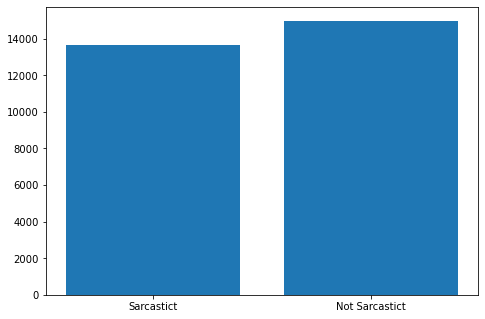

In [47]:
is_sarcastic_texts =[]
not_is_sarcastic_texts =[]
for index, row in dataframe.iterrows():
    if row['is_sarcastic'] == 1:
        is_sarcastic_texts.append(row)
    else:
        not_is_sarcastic_texts.append(row)

print("Number of Sarcastic Texts:",len(is_sarcastic_texts))
print("Number of Non Sarcastic Texts:",len(not_is_sarcastic_texts))

""" Plot the counts of sentiment and compare"""
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiments = ['Sarcastict','Not Sarcastict']
number = [len(is_sarcastic_texts),len(not_is_sarcastic_texts)]
ax.bar(sentiments,number)
plt.show() 

# Read the Data:

We will be using the torchtext library from Pytorch where we define the TEXT and LABEL field as shown below.

In [48]:
from torchtext import data
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

Using the torchtext we read the json file and as we are interested only in headlines and is_sarcastic field we ignore the article_link field in the data. Then we split the data into training data and validation data in 80:20 ratio as shown below and check the length of the training data and validation data.

In [49]:
import torchtext
TRAIN_JSON = '../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json'

fields = {'headline': ('text', TEXT), 'is_sarcastic': ('label', LABEL)}

dataset = torchtext.data.TabularDataset(path=TRAIN_JSON,format='json',fields=fields)
print(dataset)

(train_data,valid_data) = dataset.split(split_ratio=[0.8,0.1])

"""train_data, valid_data = d.split(random_state = random.seed(SEED))"""


print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(valid_data)}')

Number of training examples: 25439
Number of testing examples: 3180


Then we build the vocabulary out of our dataset. We use glove.6B.100d vectors in this notebook for the text and similarly build the vocabulary for label field as well.

In [50]:

MAX_VOCAB_SIZE = 25657

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

Then we print out the length of the vocabulary of Text and Label and make sure the len label vocabulary is 2 as we have two unique values for our label which is sarcastic and non sarcastic.

In [51]:
print(len(TEXT.vocab))
print(len(LABEL.vocab))
print(LABEL.vocab.stoi)
print(TEXT.vocab.stoi[TEXT.pad_token])

25657
2
defaultdict(None, {0: 0, 1: 1})
1


In [52]:
print(vars(train_data.examples[6]))

{'text': ['listen', 'up', '!', 'my', 'favorite', 'americana', 'discoveries', 'of', '2014'], 'label': 0}


# Batch Iterators for the data:

We define the batch size and check the device and if we have GPU access then we assign the device to cuda to train our data in GPU as shown below. We will use the BucketIterator for iterating over the training data and validation data and define the sorting mechanism in the batch as well, we will sort according to its length in a particular batch.

In [53]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE, sort_within_batch = True,
    sort_key = lambda x: len(x.text),
    device = device)

# Defining our CNN Model:

Next we define our CNN model where we define the multiple convolution neural networks according to the filter sizes.
In the first layer we define the Embedding layer and we have our convolution networks according to our filter sizes and then finally we have the Linear layer and we also add a dropout as well.
In the forward method we pass the text through embedding layer and then pass throught the convolution neural networks where we apply relu function and then maxpool them and add a dropout and then finally pass through the Linear layer to return the output.

In [54]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

# Defining the Hyperparameters

In this step, we define the input_dim, embedding dim and filters , output dim , filters and padding as shown below.

In [55]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [1,2,3]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
model

CNN(
  (embedding): Embedding(25657, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(1, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(2, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

The below method shows how many parameters the model has.

In [56]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,626,301 trainable parameters


Then we use the pretrained embeddings and copy those weights.

In [57]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.1897,  0.0500,  0.1908,  ..., -0.3980,  0.4765, -0.1598],
        ...,
        [ 0.2272, -1.8329, -1.2672,  ..., -0.8241,  1.3403,  0.9017],
        [ 0.3542,  1.3837,  0.5389,  ...,  0.4686,  0.6476, -0.8975],
        [-0.3223, -0.8340, -0.1413,  ...,  0.6861, -0.0195, -0.2755]])

In [58]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

Next we define our Optimizer, Loss functions. In this case we will be using the Adam optimizer and Binary cross entropy loss function and move the model to device to train.

In [59]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [60]:
model

CNN(
  (embedding): Embedding(25657, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(1, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(2, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [61]:
device

device(type='cuda')

Then we define the accuraccy function on to check each epoch on how our model is doing.

In [62]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# Train Model:

Then we define the training function which iterates over our training data and in calculates the loss and optimizes it at each and every step.

In [63]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Then we define the evaluate method to evaluate how well our model is doing in each epoch.

In [64]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Then define the utility function to check how much time each epoch is taking.

In [65]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

This is the main step where we actually train our model and in each epoch we record train_loss,valida_loss,train_acc and valid_acc in history.In each epoch we check if its best validation loss then we save our model.

In [66]:
history=[]

In [67]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'news-sarcasm-model-1.0.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    result = {'val_loss': valid_loss, 'val_acc': valid_acc}
    history.append(result)

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.515 | Train Acc: 74.21%
	 Val. Loss: 0.373 |  Val. Acc: 84.74%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.318 | Train Acc: 86.46%
	 Val. Loss: 0.311 |  Val. Acc: 86.73%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.227 | Train Acc: 90.93%
	 Val. Loss: 0.299 |  Val. Acc: 87.04%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.155 | Train Acc: 94.19%
	 Val. Loss: 0.322 |  Val. Acc: 87.97%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.113 | Train Acc: 96.03%
	 Val. Loss: 0.328 |  Val. Acc: 87.99%


# Plotting the Accuraccy:

Next, we plot the epoch vs accuraccy graph and from the graph we can see at each epoch the accuracy is increasing.

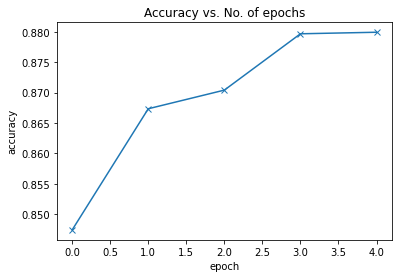

In [68]:
"""Plot the loss and accuraccy"""

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# Plotting the Loss:

Next, we define the epoc vs loss graph and from the graph we can see at each epoch the accuracy is increasing

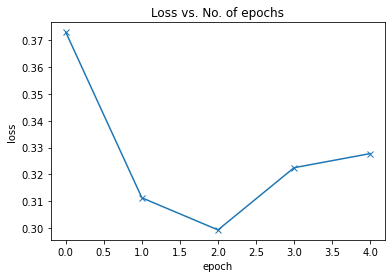

In [69]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

# Final Accuracy of our Model:

Then we calculate the final accuraccy of our model against the validation data.

In [70]:
model.load_state_dict(torch.load('news-sarcasm-model-1.0.pt'))

vall, valacc = evaluate(model, valid_iterator, criterion)

print(f'Valid Loss: {vall:.3f} | Valid Acc: {valacc*100:.2f}%')

Valid Loss: 0.299 | Valid Acc: 87.04%


# Making Predictions:

Then we define the predict method where we define pass the text through the model and according it to the output we if its near to 1 we predict it as Sarcastic and if its near to 0 we predict as Not Sarcastic.


In [71]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    print(prediction.item())
    pred = round(prediction.item())
    if pred == 1:
        return "Sarcastic"
    else:
        return "Not Sarcastic"

In [72]:
predict_sentiment(model, "product of the day: happy man #wine tool who's it's the #weekend? time to open up &amp; drink up!")

0.03369327262043953


'Not Sarcastic'

In [73]:
predict_sentiment(model, "thirtysomething scientists unveil doomsday clock of hair loss")

0.9944638609886169


'Sarcastic'

# Save and upload


In [74]:
saved_weights_fname='news-sarcasm-model-1.0.pth'

In [75]:
torch.save(model.state_dict(), saved_weights_fname)

In [76]:
!pip install jovian --upgrade --quiet

In [77]:
import jovian


<IPython.core.display.Javascript object>

In [78]:
jovian.commit(project="News Headlines Sarcasm Detection", environment=None, outputs=[saved_weights_fname])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/siddeshbb/News Headlines Sarcasm Detection


<IPython.core.display.Javascript object>